In [1]:
# In VS IDE terminal the following installation need to be done:
# pip install requests
# pip install pandas
# pip install bs4

import requests
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from datetime import datetime 

In [2]:
url = 'https://web.archive.org/web/20230908091635 /https://en.wikipedia.org/wiki/List_of_largest_banks'
table_attribs = ["Name", "MC_USD_Billion"]
currency_csv_path = 'exchange_rate.csv'
csv_output_path = './Largest_banks_data.csv'
db_name = 'Banks.db'
table_name = 'Largest_banks'
log_file = 'code_log.txt'

In [3]:
def log_progress(message):
    ''' This function logs the mentioned message of a given stage of the
    code execution to a log file. Function returns nothing'''
    
    timestamp_format = '%Y-%h-%d-%H:%M:%S' # Year-Monthname-Day-Hour-Minute-Second 
    now = datetime.now() # get current timestamp 
    timestamp = now.strftime(timestamp_format) 
    with open(log_file,"a") as f: 
        f.write(timestamp + ' : ' + message + '\n') 

In [4]:
def extract(url, table_attribs):
    ''' This function aims to extract the required
    information from the website and save it to a data frame. The
    function returns the data frame for further processing. '''
    
    page = requests.get(url).text
    data = BeautifulSoup(page,'html.parser')
    df = pd.DataFrame(columns=table_attribs)
    tables = data.find_all('tbody')
    rows = tables[0].find_all('tr')        
        
    for row in rows:
        col = row.find_all('td')
        if len(col) != 0:
            name = col[1].find_all('a')[1].contents[0]
            USD_curr = col[2].contents[0].strip()
            data_dict = {table_attribs[0]: name,
                         table_attribs[1]: USD_curr}
            df1 = pd.DataFrame(data_dict, index=[0])
            df = pd.concat([df,df1], ignore_index=True) 

    return df

In [5]:
# assigning the extract() function output to a variable so we can use it in the transform() function:
df = extract(url, table_attribs)

In [6]:
# taking a look at the extract() function output:
df

,Name,MC_USD_Billion
0,JPMorgan Chase,432.92
1,Bank of America,231.52
2,Industrial and Commercial Bank of China,194.56
3,Agricultural Bank of China,160.68
4,HDFC Bank,157.91
5,Wells Fargo,155.87
6,HSBC Holdings PLC,148.90
7,Morgan Stanley,140.83
8,China Construction Bank,139.82
9,Bank of China,136.81


In [7]:
def transform(df, csv_path):
    ''' This function accesses the CSV file for exchange rate
    information, and adds three columns to the data frame, each
    containing the transformed version of Market Cap column to
    respective currencies'''
    
    dataframe = pd.read_csv(csv_path)
    exchange_rate = dataframe.set_index('Currency').to_dict()['Rate']
    df['MC_EUR_Billion'] = [np.round(float(x) * exchange_rate['EUR'], 2) for x in df['MC_USD_Billion']]
    df['MC_GBP_Billion'] = [np.round(float(x) * exchange_rate['GBP'], 2) for x in df['MC_USD_Billion']]
    df['MC_INR_Billion'] = [np.round(float(x) * exchange_rate['INR'], 2) for x in df['MC_USD_Billion']]
    
    return df

In [8]:
# taking a look a the transform() function output:
transform(df, currency_csv_path)

,Name,MC_USD_Billion,MC_EUR_Billion,MC_GBP_Billion,MC_INR_Billion
0,JPMorgan Chase,432.92,402.62,346.34,35910.71
1,Bank of America,231.52,215.31,185.22,19204.58
2,Industrial and Commercial Bank of China,194.56,180.94,155.65,16138.75
3,Agricultural Bank of China,160.68,149.43,128.54,13328.41
4,HDFC Bank,157.91,146.86,126.33,13098.63
5,Wells Fargo,155.87,144.96,124.70,12929.42
6,HSBC Holdings PLC,148.90,138.48,119.12,12351.26
7,Morgan Stanley,140.83,130.97,112.66,11681.85
8,China Construction Bank,139.82,130.03,111.86,11598.07
9,Bank of China,136.81,127.23,109.45,11348.39


In [9]:
def load_to_csv(df, output_path):
    ''' This function saves the final data frame as a CSV file in
    the provided path. Function returns nothing.'''
    df.to_csv(output_path)

In [10]:
def load_to_db(df, sql_connection, table_name):
    ''' This function saves the final data frame to a database
    table with the provided name. Function returns nothing.'''
    df.to_sql(table_name, sql_connection, if_exists='replace', index=False)

In [11]:
def run_query(query_statement, sql_connection):
    ''' This function runs the query on the database table and
    prints the output on the terminal. Function returns nothing. '''
    print(query_statement)
    query_output = pd.read_sql(query_statement, sql_connection)
    print(query_output)

In [12]:
log_progress('Preliminaries complete. Initiating ETL process')

df = extract(url, table_attribs)

log_progress('Data extraction complete. Initiating Transformation process')

df = transform(df, currency_csv_path)

log_progress('Data transformation complete. Initiating Loading process')

load_to_csv(df, csv_output_path)

log_progress('Data saved to CSV file')

sql_connection = sqlite3.connect(db_name)

log_progress('SQL Connection initiated.')

load_to_db(df, sql_connection, table_name)

log_progress('Data loaded to Database as table, Executing queries')

print('1. Print the contents of the entire table:\n')

query_statement = f"SELECT * FROM Largest_banks"
run_query(query_statement, sql_connection)

print('\n2. Print the average market capitalization of all the banks in Billion USD:\n')

query_statement = f"SELECT AVG(MC_USD_Billion) FROM Largest_banks"
run_query(query_statement, sql_connection)

print('\n3. Print only the names of the top 5 banks:\n')

query_statement = f"SELECT Name from Largest_banks LIMIT 5"
run_query(query_statement, sql_connection)


log_progress('Process Complete')

sql_connection.close()

log_progress('Server Connection closed')

1. Print the contents of the entire table:

SELECT * FROM Largest_banks
                                      Name MC_USD_Billion  MC_EUR_Billion  \
0                           JPMorgan Chase         432.92          402.62   
1                          Bank of America         231.52          215.31   
2  Industrial and Commercial Bank of China         194.56          180.94   
3               Agricultural Bank of China         160.68          149.43   
4                                HDFC Bank         157.91          146.86   
5                              Wells Fargo         155.87          144.96   
6                        HSBC Holdings PLC         148.90          138.48   
7                           Morgan Stanley         140.83          130.97   
8                  China Construction Bank         139.82          130.03   
9                            Bank of China         136.81          127.23   

   MC_GBP_Billion  MC_INR_Billion  
0          346.34        35910.71  
1       

#### However, running the code in IDE may provide a better view:

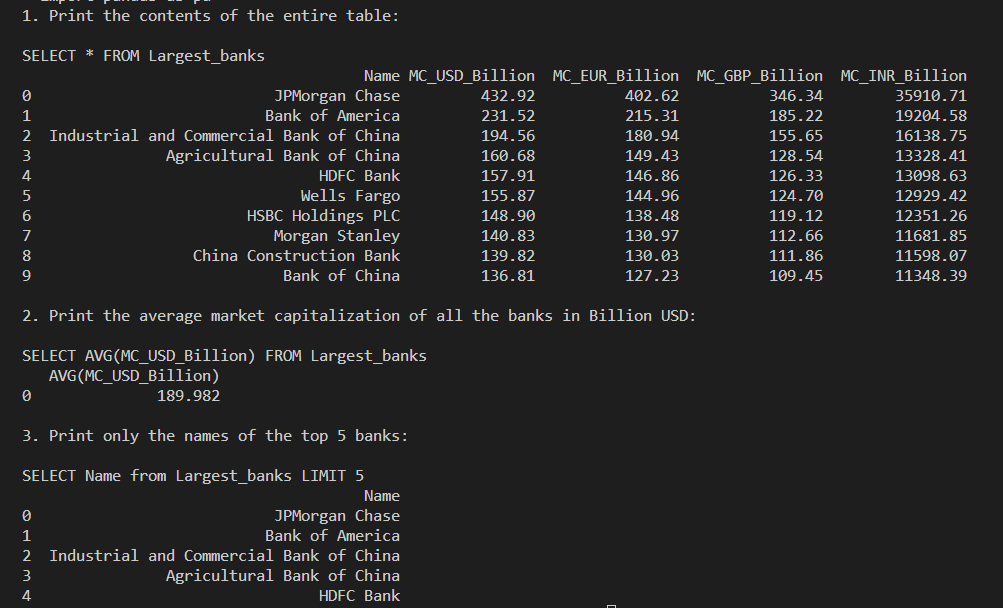

The code_log.txt content after running the code:

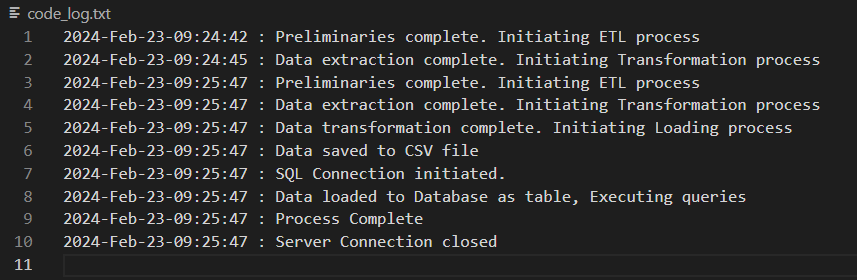

The Largest_banks_data.csv content after running the code:

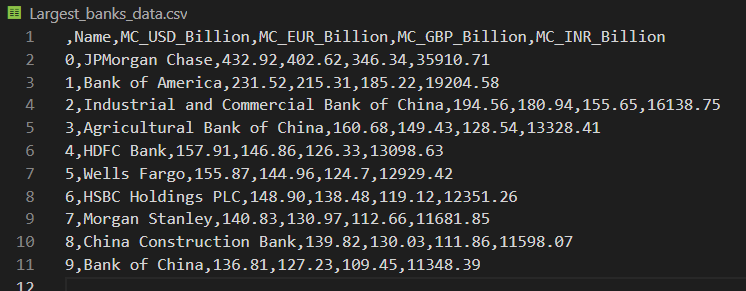

Using SQLlite viewer in VS to look at the database created by running the code:

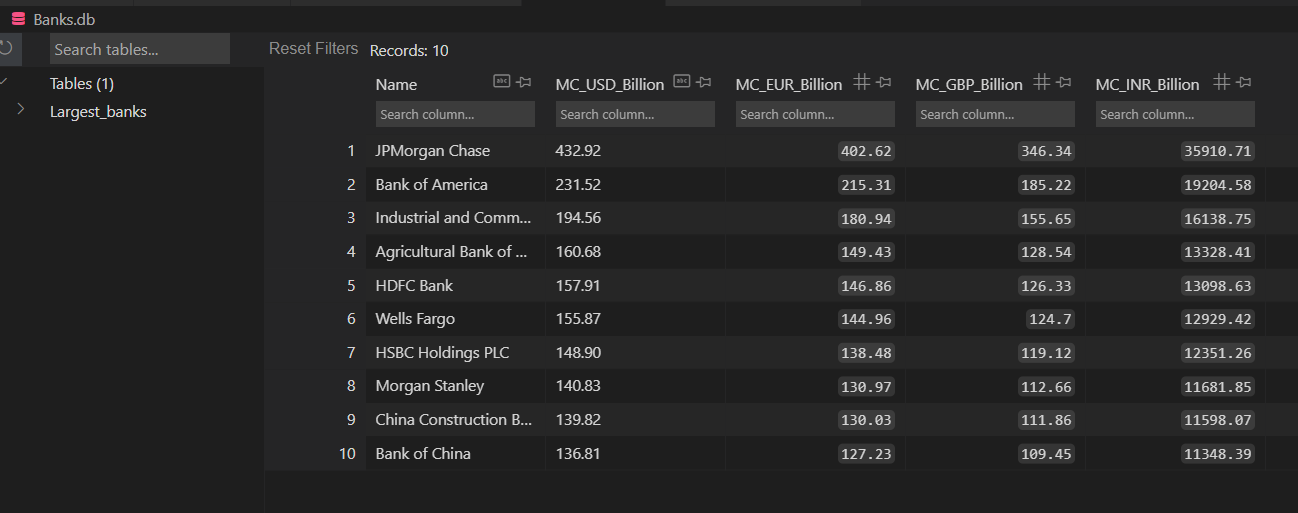